In [1]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
import collections
from collections import Counter
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import random
import xgboost as xgb

## Data prepocessing

In [4]:
# format : qid pid queries passage relevancy
# 4364339 rows × 5 columns
train_data = pd.read_csv('train_data.tsv', sep='\t',header=0,low_memory=False)
train_data

,qid,pid,queries,passage,relevancy
0,188714,1000052,foods and supplements to lower blood sugar,Watch portion sizes: ■ Even healthy foods will...,0.0
1,995526,1000094,where is the federal penitentiary in ind,It takes THOUSANDS of Macy's associates to bri...,0.0
2,660957,1000115,what foods are good if you have gout?,The good news is that you will discover what g...,0.0
3,837202,1000252,what is the nutritional value of oatmeal,"Oats make an easy, balanced breakfast. One cup...",0.0
4,130825,1000268,definition for daring,Such a requirement would have three desirable ...,0.0
...,...,...,...,...,...
4364334,146812,999890,difference between coating and laminating,Examples of conformal coating capillary flow E...,0.0
4364335,1067772,999933,what is a sabbatical policy for nonprofit,Corporate Records for Nonprofit Corporations. ...,0.0
4364336,679360,999933,what is a corporate bylaws,Corporate Records for Nonprofit Corporations. ...,0.0
4364337,43781,999956,average savings per age group,When it comes to average retirement savings st...,0.0


In [2]:
# format : qid pid queries passage relevancy
# 1103039 rows × 5 columns
validation_data = pd.read_csv('validation_data.tsv', sep='\t',header=0,low_memory=False)

In [3]:
validation_data

,qid,pid,queries,passage,relevancy
0,1082792,1000084,what does the golgi apparatus do to the protei...,"Start studying Bonding, Carbs, Proteins, Lipid...",0.0
1,995825,1000492,where is the graphic card located in the cpu,"For example, a “PC Expansion Card” maybe the j...",0.0
2,995825,1000494,where is the graphic card located in the cpu,The Common Cards & Buses. The most common type...,0.0
3,1091246,1000522,property premises meaning,The occurrence of since tells us that the firs...,0.0
4,1047854,1000585,what is printing mechanism,Windows desktop applications Develop Desktop t...,0.0
...,...,...,...,...,...
1103034,176994,999706,dynamic link library meaning,Internet Public Library – The Internet Public ...,0.0
1103035,1089177,999765,united home life insurance phone number,Geico Customer Service Phone Number: 1-800-861...,0.0
1103036,42555,999824,average salary for primary care sports medicin...,The current average NBA salary of $6.2 million...,0.0
1103037,1044249,999824,what is the average salary of an nba player,The current average NBA salary of $6.2 million...,0.0


In [3]:
def preprocessing(text, stopword_removal = False, lemma = False):
    """
        A text preprocessing function
        Inputs:
          text: input queries/passages
          stopword_removal: remove all stopwords if True
          lemma: do lemmatisation and stemming if True
        Outputs:
          passage: queries/passages after preprocessing
    """
    stop_words = set(stopwords.words('english')) 
    word_tokens = RegexpTokenizer(r'\s+', gaps=True)
    passage = []
    for i in range(len(text)):
        words = text[i].lower()
        # remove punctuation
        rm_punc =re.compile('[%s]' % re.escape(string.punctuation))
        words = rm_punc.sub('', words)
        # remove all the numbers
        words = re.sub(r'[^a-zA-Z\s]', u' ', words, flags=re.UNICODE)
        # tokenize
        token_words = word_tokens.tokenize(words)
        
        # stop word removal
        if (stopword_removal == True):
            token_words = [w for w in token_words if not w in stop_words]
        
        sentence = []
        # lemmatisation & stemming
        if (lemma == True):
            stemmer = SnowballStemmer('english')
            for i in token_words:      
                sentence.append(stemmer.stem(i))
        else:
            sentence = token_words
        passage.append(sentence) 
    return passage

In [ ]:
# 1103039 rows
clean_validation_query = preprocessing(validation_data.queries, stopword_removal = True, lemma = True)
clean_validation_passage = preprocessing(validation_data.passage, stopword_removal = True, lemma = True)

In [ ]:
# 1148 qids and queries
qid_query_valid = dict(zip(validation_data.qid,clean_validation_query))

# 955211 pids and passage
pid_passage_valid = dict(zip(validation_data.pid,clean_validation_passage)) 

In [5]:
#np.save('qid_query_valid.npy',qid_query_valid)
#np.save('pid_passage_valid.npy',pid_passage_valid)
qid_query_valid = np.load('qid_query_valid.npy',allow_pickle=True).tolist()
pid_passage_valid = np.load('pid_passage_valid.npy',allow_pickle=True).tolist()

## Task 1 Evaluating Retrieval Quality

In [6]:
def inv_index(pid_passage_dict):
    """
        A inverted index function
        Inputs:
          pid_passage_dict: dictionary with a format of {pid:passage}
        Outputs:
          inverted_index: dictionary with a format of {token: repeat times}
    """
    inverted_index = {}
    pid_dict = pid_passage_dict.keys()
    for pid in pid_dict:
        passage = pid_passage_dict[pid]
        for token in passage:
            num = passage.count(token)
            if token not in inverted_index.keys():
                inverted_index[token] = {pid:num} 
            elif token in inverted_index.keys():
                new_pid = {pid: num}
                inverted_index[token].update(new_pid) 
    return inverted_index

In [7]:
inverted_index = inv_index(pid_passage_valid)
#np.save('inverted_index.npy',inverted_index)
#inverted_index = np.load('inverted_index.npy',allow_pickle=True).tolist()
#inverted_index['start']

In [8]:
length = 0
for pid in pid_passage_valid.keys():
    length += len(pid_passage_valid[pid])
avdl = length/len(pid_passage_valid.keys()) # 32.209788203862814
N = len(validation_data) # 1103039

In [335]:
# 1103039 rows
qid_list = list(validation_data.qid)
pid_list = list(validation_data.pid)
def qid_to_pid(qid,qid_list,pid_list):
    pid = []
    index = [i for i,x in enumerate(qid_list) if x == qid ]
    for i in range(len(index)):
        pid.append(pid_list[index[i]])
    return pid,index

In [10]:
def BM25(qid,pid_passage_dict,qid_query_dict,inverted_index,k1=1.2,k2=100,b=0.75,cutoff=100):
    """
        A BM25 function
        Inputs:
          qid: query id
          pid_passage_dict: dictionary with a format of {pid:passage}
          qid_query_dict: dictionary with a format of {qid:query}
          inverted_index: dictionary with a format of {token: repeat times}
        Outputs:
          top100_score: dictionary with a format of {pid: BM25 scores}
    """
    query = qid_query_dict[qid] # qid query
    pids,ind = qid_to_pid(qid,qid_list,pid_list) # coresponding pid
    count_words_q = Counter(query)
    tokens = count_words_q.most_common(len(count_words_q))
    score_list = {}
    for j in range(len(pids)):
        pid = pids[j]
        passage = pid_passage_dict[pid] # passage
        dl = len(passage)
        K = k1*((1-b)+b*dl/avdl)
        score = 0
        for i in range(len(tokens)):
            token = tokens[i][0]
            qfi = tokens[i][1]
            if token in passage:
                fi = inverted_index[token][pid]
                ni = len(inverted_index[token])
            else:
                fi = 0
                ni = 0
            score += np.log( ((0+0.5)/(0-0+0.5)) /((ni-0+0.5)/(N-ni-0))) * (k1+1)*fi*(k2+1)*qfi / ((K+fi)*(k2+qfi))
        Scores = {pid:score}
        score_list = {**score_list ,**Scores}
    top100_score = dict(sorted(score_list.items(), key=lambda x: x[1], reverse=True)[:cutoff])
    return top100_score

In [11]:
BM25_score_100 = {}
for qid in qid_query_valid.keys():
    top100_BM25 = BM25(qid,pid_passage_valid,qid_query_valid,inverted_index,k1=1.2,k2=100,b=0.75,cutoff=100)
    Scores = {qid:top100_BM25}
    BM25_score_100 = {**BM25_score_100 ,**Scores}

BM25_score_10 = {}
for qid in qid_query_valid.keys():
    top10_BM25 = BM25(qid,pid_passage_valid,qid_query_valid,inverted_index,k1=1.2,k2=100,b=0.75,cutoff=10)
    Scores = {qid:top10_BM25}
    BM25_score_10 = {**BM25_score_10 ,**Scores}
    
BM25_score_3 = {}
for qid in qid_query_valid.keys():
    top3_BM25 = BM25(qid,pid_passage_valid,qid_query_valid,inverted_index,k1=1.2,k2=100,b=0.75,cutoff=3)
    Scores = {qid:top3_BM25}
    BM25_score_3 = {**BM25_score_3 ,**Scores}

In [12]:
def Relevant_dict(data):
    """
        A relevant and irrelevant passage function
        Inputs:
          data: input dataset
        Outputs:
          relevant_dict: relevant passage dictionary with a format of {qid: {pid, position}}
          irrelevant_dict: irrelevant passage dictionary with a format of {qid: {pid, position}}
    """
    qid_list = data.qid
    pid_list = data.pid
    relevancy_list = data.relevancy
    relevant_dict = {}
    irrelevant_dict = {}
    for ind,qid in enumerate(qid_list):
        pid = pid_list[ind]
        relevancy = relevancy_list[ind]
        if relevancy > 0:
            if qid not in relevant_dict.keys():
                relevant_dict[qid] = {pid:ind}
            elif qid in relevant_dict.keys():
                new_pid = {pid:ind}
                relevant_dict[qid].update(new_pid)
        else:
            if qid not in irrelevant_dict.keys():
                irrelevant_dict[qid] = {pid:ind}
            elif qid in irrelevant_dict.keys():
                new_pid = {pid:ind}
                irrelevant_dict[qid].update(new_pid)

    return relevant_dict,irrelevant_dict

valid_relevant_dict, valid_irrelevant_dict = Relevant_dict(validation_data)
# 1148 qids
# valid_relevant_dict[1082792]  # given qid, return relevant pids and positions in validation_data
# valid_irrelevant_dict[1082792] # given qid, return irrelevant pids and positions in validation_data
# len(valid_irrelevant_dict[995825])
# validation_data[ind:ind+1]

In [578]:
def mean_AP(model):
    """
        A mean average precision function
        Inputs:
          model: retrivel systems
        Outputs:
           np.mean(AP): mean average precision
           AP: a list containing APs for each query
    """
    AP = []
    qid_list = model.keys()
    
    # for each query
    for qid in qid_list: 
        # find all the relevant pid for this qid
        rel_pid = valid_relevant_dict[qid]
        
        # if the model does not retrieve any relevant pid, Precision is 0
        fail_to_find = [False for i in rel_pid.keys() if i not in model[qid].keys()]
        if fail_to_find:
            metric = 0
        
        # if the model retrieves relevant pids
        else:
            # RR      Relevant Retrieved
            # TR      Current Ranking
            RR = 0
            TR = 0
            Precision = 0
            
            # for each pid retrieved for this qid
            for i in model[qid].keys():
                TR += 1
                # if retrieved a relevant pid, RR add 1, Precision = RR/TR * relevancy
                if i in rel_pid.keys():
                    RR += 1
                    rel = float(validation_data[rel_pid[i]:rel_pid[i]+1].relevancy)
                    Precision += RR / TR * rel
                
                # if retrieved a relevant pid, RR add 1, Precision = RR/TR
                else:
                    Precision += 0 
                    
                # if finding all the relevant pids, stop
                if RR == len(rel_pid.keys()):
                    break   
                    
            # average precision
            metric = Precision / RR 
        
        AP.append(metric)
    
    return  np.mean(AP), AP

In [14]:
mAP_100, AP_100 = mean_AP(BM25_score_100)  # 0.23294399130269514
mAP_10, AP_10 = mean_AP(BM25_score_10) #  0.21670538133952771
mAP_3, AP_3 = mean_AP(BM25_score_3) # 0.17668408826945411

In [26]:
mAP_100

0.23294399130269514

In [27]:
mAP_10

0.21670538133952771

In [28]:
mAP_3

0.17668408826945411

In [579]:
def mean_NDCG(model):
    """
        A mean NDCG function
        Inputs:
          model: retrivel systems
        Outputs:
           np.mean(NDCG): mean NDCG
           NDCG: a list containing NDCGs for each query
    """
    NDCG = []
    qid_list = model.keys()
    
    # for each query
    for qid in qid_list:
        # find all the relevant pid for this qid
        rel_pid = valid_relevant_dict[qid]
        
        # if the model does not retrieve any relevant pid, NDCG is 0
        fail_to_find = [False for i in rel_pid.keys() if i not in model[qid].keys()]
        if fail_to_find:
            metric = 0   
            
        # if the model retrieves relevant pids
        else:
            opt_dict = {} # create a list to store the perfect ranking
            
            # for each pid in relevant pid for this qid
            for i in rel_pid.keys():
                DCG = 0
                
                # if the relevant pid is retrieved, DCG = (2^rel-1)/log_2(rank+1)
                if i in model[qid].keys():
                    rel = float(validation_data[rel_pid[i]:rel_pid[i]+1].relevancy)
                    rank = list(model[qid].keys()).index(i) + 1
                    DCG += (2**rel-1) / np.log2(rank + 1)
                    
                # rerank by optimal ranking
                for ind in rel_pid.values():
                    opt = {i:validation_data.relevancy[ind]}
                    opt_dict = {**opt_dict,**opt} 
                Opt_dict = [(k,opt_dict[k]) for k in sorted(opt_dict.keys(),reverse = True)] 
                
                opt_DCG = 0 
                for i in range(len(Opt_dict)):
                    rel = Opt_dict[i][1]
                    rank = i+1
                    opt_DCG += (2**rel-1) / np.log2(rank + 1)
            
            # NDCG
            metric = DCG / opt_DCG
        
        NDCG.append(metric)
        
    return np.mean(NDCG), NDCG 

In [19]:
mNDCG_100, NDCG_100 = mean_NDCG(BM25_score_100) # 0.3440848330645072
mNDCG_10, NDCG_10 = mean_NDCG(BM25_score_10) # 0.27675667124740916
mNDCG_3, NDCG_3 = mean_NDCG(BM25_score_3) # 0.19790956977041063

In [23]:
mNDCG_100

0.3440848330645072

In [24]:
mNDCG_10

0.27675667124740916

In [25]:
mNDCG_3

0.19790956977041063

## Task 2 Logistic Regression (LR)

In [ ]:
# format : qid pid queries passage relevancy
# 4364339 rows × 5 columns
train_data = pd.read_csv('train_data.tsv', sep='\t',header=0,low_memory=False)

train_relevant_dict, train_irrelevant_dict = Relevant_dict(train_data)
#len(train_relevant_dict.keys()) # 4590
#len(train_irrelevant_dict.keys()) # 4589

In [30]:
def subsampling(data):
    """
        A subsampling function
        Inputs:
          data: input dataset
        Outputs:
           dataset after negative down sampling
    """
    # a list store all subsamples' positions selected
    DF_list = []
    
    # for each query
    for qid in train_relevant_dict.keys():   
        
        # keep all relevant passage, record their positions
        rel_list = list(train_relevant_dict[qid].values())
        
        # random choose samples from irrelevant passage with a rate of 0.025, 
        # record their positions
        if qid not in train_irrelevant_dict.keys():
            irrel_list = []
            
        else:
            L = list(train_irrelevant_dict[qid].values())
            
            # if the number of irrelevant passages for this qid is samller than 25, 
            # keep all irrelevant passages
            if len(L) <= 25:
                irrel_list = L
                
            # if the number of irrelevant passages for this qid is larger than 25,
            # choose them by the rate of 0.025
            else:
                irrel_list = random.sample(L,25) 
                # choose 25 here, since most amount of irrelevant passages is around 1000
                # 1000*0.025 = 25
        
        sample_ind = rel_list + irrel_list
        DF_list += sample_ind  
    
    # convert positions to their corresponding rows
    NewData = []
    for i in DF_list:
        newdata = data[i:i+1]
        NewData.append(newdata)
    
    # merge all the subsamples and convert to a dataFrame
    return pd.concat(NewData,axis=0,ignore_index=True)

In [35]:
train_subdata = subsampling(train_data)

In [36]:
train_subdata # 118434 rows

,qid,pid,queries,passage,relevancy
0,709560,1050990,what is all in basic metabolic panel,Basic Metabolic Panel. The basic metabolic pan...,1.0
1,709560,4108232,what is all in basic metabolic panel,Arthritis Advanced Panel; Arthritis Basic Pane...,0.0
2,709560,1968661,what is all in basic metabolic panel,"1 Chondromalacia patellae, a degenerative cond...",0.0
3,709560,7051083,what is all in basic metabolic panel,"Nationally, the average installation cost of a...",0.0
4,709560,7821072,what is all in basic metabolic panel,A basic home security system is comprised of a...,0.0
...,...,...,...,...,...
118429,969974,1128768,where did the the trail of tears end,Vaginal tears are rips in the skin and muscle ...,0.0
118430,969974,2569621,where did the the trail of tears end,"No, the Trail of Tears did not include the Sio...",0.0
118431,969974,5850920,where did the the trail of tears end,Over 3000 Cherokee die on the trail. Over 1600...,0.0
118432,969974,7824216,where did the the trail of tears end,Debates about the impact of epidemic disease a...,0.0


In [37]:
subtrain_relevant_dict, subtrain_irrelevant_dict = Relevant_dict(train_subdata)
#len(subtrain_relevant_dict.keys())   # 4590 qids
#len(subtrain_irrelevant_dict.keys())  # 4589 qids

In [40]:
# 118434 rows
clean_train_passage = preprocessing(train_subdata.passage, stopword_removal = True, lemma = True)
clean_train_query = preprocessing(train_subdata.queries, stopword_removal = True, lemma = True)

In [41]:
# 4590 qids and queries
qid_query_train = dict(zip(train_subdata.qid,clean_train_query))

# 115475 pids and passage
pid_passage_train = dict(zip(train_subdata.pid,clean_train_passage)) 

In [42]:
#np.save('qid_query_train.npy',qid_query_valid)
#np.save('pid_passage_train.npy',pid_passage_valid)
#qid_query_train = np.load('qid_query_train.npy',allow_pickle=True).tolist()
#pid_passage_train = np.load('pid_passage_train.npy',allow_pickle=True).tolist()

In [43]:
# word emebedding for passage in training data
with open('clean_train_passage.txt','w') as f:
    for i in range(len(clean_train_passage)):
        f.write(' '.join(clean_train_passage[i])+'\n')
        
sentences = LineSentence('clean_train_passage.txt')
model_train_passage = Word2Vec(sentences, sg=1, vector_size=100, window=5, min_count=1,negative=5,hs=0, workers=4)

In [44]:
# word emebedding for query in training data
with open('clean_train_query.txt','w') as f:
    for i in range(len(clean_train_query)):
        f.write(' '.join(clean_train_query[i])+'\n')

sentences = LineSentence('clean_train_query.txt')
model_train_query = Word2Vec(sentences, sg=1, vector_size=100, window=5, min_count=1,negative=5,hs=0, workers=4)

In [47]:
# word emebedding for passage in test data
with open('clean_validation_passage.txt','w') as f:
    for i in range(len(clean_validation_passage)):
        f.write(' '.join(clean_validation_passage[i])+'\n')

sentences = LineSentence('clean_validation_passage.txt')
model_valid_passage = Word2Vec(sentences, sg=1, vector_size=100, window=5, min_count=1,negative=5, hs=0, workers=4)

In [48]:
# word emebedding for query in test data
with open('clean_validation_query.txt','w') as f:
    for i in range(len(clean_validation_query)):
        f.write(' '.join(clean_validation_query[i])+'\n')

sentences = LineSentence('clean_validation_query.txt')
model_valid_query = Word2Vec(sentences, sg=1, vector_size=100, window=5, min_count=1,negative=5, hs=0, workers=4)

In [265]:
def average_embedding(data,model):
    """
        A average embedding function
        Inputs:
          data: input dictionary with format of {ind: query/passage}
          model: word vector model
        Outputs:
           EM: dictionary with a format of {ind: average embedding for query/passage}
    """    
    EM = {} # empty dictionary
    
    # for each index in dataset
    for i in data.keys():
        text = data[i] # corresponding passage/query
        n = len(text) # length of passage/query
        
        # if the passage/query is not empty
        if n != 0:
            # sum the word vectors for each token in passage/query and then average them
            text_vector = sum(model.wv[text])/n 
                
            # store in a dictionary
            em = {i:text_vector}
            EM = {**EM ,**em}  
        
    return EM

In [50]:
embedding_train_query = average_embedding(qid_query_train, model_train_query) # 4589
embedding_train_passage = average_embedding(pid_passage_train, model_train_passage) # 115475
embedding_valid_query = average_embedding(qid_query_valid, model_valid_query) # 1148
embedding_valid_passage = average_embedding(pid_passage_valid, model_valid_passage) # 955211

In [263]:
#np.save('embedding_train_query.npy',embedding_train_query)
#np.save('embedding_train_passage.npy',embedding_train_passage)
#np.save('embedding_valid_query.npy',embedding_valid_query)
#np.save('embedding_valid_passage.npy',embedding_valid_passage)

In [266]:
def new_dataset(data, embedding_query, embedding_passage, relevant_dict):
    """
        A function construct new dataFrame with format <qid, pid, query vector, passage vector, relevancy>
        Inputs:
          data: original dataset 
          embedding_query: embeddings for queries in data
          embedding_passage: embeddings for passages in data
          relevant_dict: relevancy in data
        Outputs:
           new_dataFrame: same as original dataset with query and passage columns changing to embedding vectors
    """
    QID = []
    PID = []
    Query = []
    Passage = []
    Rel = []
    for i in range(len(data)):
        qid = data.qid[i]
        pid = data.pid[i]
        if qid in embedding_query.keys() and pid in embedding_passage.keys():
            query_vec = embedding_query[qid]
            passage_vec = embedding_passage[pid]
            QID.append(qid)
            PID.append(pid)
            Query.append(query_vec)
            Passage.append(passage_vec)
            if pid in relevant_dict[qid].keys():
                i = relevant_dict[qid][pid]
                rel = float(data[i:i+1].relevancy)
            else:
                rel = 0
            Rel.append(rel)
            
    new_data = list(zip(QID,PID,Query,Passage,Rel)) 
    new_dataFrame = pd.DataFrame(data = new_data, columns=['qid','pid','q_vec','p_vec','relevancy'])
    
    return new_dataFrame   

In [52]:
train_wv = new_dataset(train_subdata, embedding_train_query, embedding_train_passage, subtrain_relevant_dict)
train_wv # 118425 rows

,qid,pid,q_vec,p_vec,relevancy
0,709560,1050990,"[-0.601977, 0.021912381, 0.31734845, 0.1325412...","[-0.33114117, 0.039900713, 0.3048746, 0.410622...",1.0
1,709560,4108232,"[-0.601977, 0.021912381, 0.31734845, 0.1325412...","[-0.4348629, 0.1469422, 0.28970575, 0.38280246...",0.0
2,709560,1968661,"[-0.601977, 0.021912381, 0.31734845, 0.1325412...","[-0.25678402, 0.00045697126, 0.31876642, 0.289...",0.0
3,709560,7051083,"[-0.601977, 0.021912381, 0.31734845, 0.1325412...","[-0.55879176, -0.045497097, 0.47804147, 0.3886...",0.0
4,709560,7821072,"[-0.601977, 0.021912381, 0.31734845, 0.1325412...","[-0.3796623, 0.0027718602, 0.54213035, 0.28753...",0.0
...,...,...,...,...,...
118420,969974,1128768,"[-0.1352244, 0.53238493, 0.12441089, -0.067843...","[-0.2975647, -0.036808204, 0.31054476, 0.45022...",0.0
118421,969974,2569621,"[-0.1352244, 0.53238493, 0.12441089, -0.067843...","[-0.44293305, 0.04839807, 0.29076046, 0.231324...",0.0
118422,969974,5850920,"[-0.1352244, 0.53238493, 0.12441089, -0.067843...","[-0.41554868, -0.0059732995, 0.34408972, 0.215...",0.0
118423,969974,7824216,"[-0.1352244, 0.53238493, 0.12441089, -0.067843...","[-0.5201574, 0.004953218, 0.2842714, 0.1944036...",0.0


In [267]:
valid_wv = new_dataset(validation_data, embedding_valid_query, embedding_valid_passage, valid_relevant_dict)
valid_wv # 1103039

,qid,pid,q_vec,p_vec,relevancy
0,1082792,1000084,"[-0.31481057, 0.28199807, -0.5663802, -0.29393...","[-0.16405553, 0.41408366, 0.17501464, 0.359596...",0.0
1,995825,1000492,"[-0.37353486, 0.70045465, -0.3091957, 0.501062...","[0.023578381, 0.22029835, 0.13351722, 0.172922...",0.0
2,995825,1000494,"[-0.37353486, 0.70045465, -0.3091957, 0.501062...","[0.12309674, 0.16059013, 0.19236642, 0.2655729...",0.0
3,1091246,1000522,"[-0.3628954, 0.48638174, 0.09927406, 0.8478671...","[-0.2230377, 0.3507099, -0.048584454, 0.024885...",0.0
4,1047854,1000585,"[-0.47890276, 0.16813879, -0.015526876, -0.446...","[0.1533783, 0.19576941, -0.024532253, 0.405404...",0.0
...,...,...,...,...,...
1103034,176994,999706,"[-0.14125563, 0.87192017, 0.36987644, 0.559300...","[-0.18349215, 0.3699503, 0.031022163, 0.115937...",0.0
1103035,1089177,999765,"[-0.62327164, 0.37024447, -0.37981835, -0.1094...","[0.32846057, 0.21391338, -0.3928629, -0.485633...",0.0
1103036,42555,999824,"[-0.6363551, 1.0190878, 0.21523039, -0.6662892...","[0.064210616, 0.33399525, 0.34879756, 0.073910...",0.0
1103037,1044249,999824,"[-0.6128874, 0.9128685, 0.012990259, -0.293684...","[0.064210616, 0.33399525, 0.34879756, 0.073910...",0.0


## Construct Train dataset

In [55]:
train_wv.insert(2,'One',1)
dataset_train = train_wv.values # convert dateFrame to matrix

In [384]:
def sigmoid(z):
    """
        A sigmoid function
    """
    return 1 / (1 + np.exp(-z))

def model_func(X,w):
    """
        A  logistic function 
    """
    return sigmoid(np.dot(X,w.T))

def pred_func(w, X):
    """
       A  predict function 
    """
    return model_func(X,w)

def loss_func(X,y,w):
    """
       A  loss function 
    """   
    sigma = model_func(X,w)
    loss = -np.sum(np.multiply(y,np.log(sigma))+np.multiply(1-y,np.log(1 - sigma)))/len(X)
    return loss
    
def grad_func(X,y,w):
    """
       Partial derivative of loss function 
    """       
    n, d = X.shape
    grad = np.zeros((d))
    diff = [a - b for a,b in zip(y, model_func(X,w))] 
    for j in range(d):
        x_ij = X[:,j]
        grad[j] = -np.sum(np.multiply(x_ij,diff))/n
    return grad  

In [214]:
def shuffleData(dataset):
    """
       Shuffle dataset and separate data inputs and labels
       Outputs:
          X_train: data inputs
          y_train: data labels
    """   
    np.random.shuffle(dataset)
    X_inputs = dataset[:,2:5]
    X_train = []
    for i in range(len(X_inputs)):
        x = np.hstack((X_inputs[i][0], X_inputs[i][1],X_inputs[i][2]))
        X_train.append(x)
        
    X_train = np.array(X_train) # (118425, 201)
    y_train = np.array(dataset[:,5:6]) # (118425, 1)
    
    return X_train,y_train

In [430]:
def grad_descent(data, step_size, max_iter, lr, tol):
    """
        Mini batch stochastic gradient descent
        Inputs:
          data: training dataset
          step_size: batch size 
          max_iter: max iterations
          lr: learning rate
          tol: tolerance
        Outputs:
           new_dataFrame: same as original dataset with query and passage columns changing to embedding vectors
    """
    iteration = 0
    step = 0
    X,y = shuffleData(data)
    w = np.zeros([1,201]) # inital weight 
    grad = np.zeros(len(w))
    Loss = []
    stop_Criterion = True
    
    while (iteration < max_iter and stop_Criterion == True):
        loss = loss_func(X,y,w)
        grad = grad_func(X[step:step+step_size], y[step:step+step_size], w)
        w -= lr*grad
        step += step_size
        if step >= len(X):
            step = 0
            X,y = shuffleData(data)
        #for i in range(len(w)):
        #    w[i] -= lr*grad[i]
        Loss.append(loss)
        iteration += 1       
        
        # stop_Criterion
        if np.linalg.norm(grad) < tol:
            stop_Criterion == False
            
    return w, Loss, iteration-1

In [227]:
def logistic_experiment_lr(data,step_size,max_iter,lr,tol):
    """
        Analyze the effect of the learning rate on the model training loss.
        Inputs:
          data: training dataset
          step_size: batch size 
          max_iter: max iterations
          lr: learning rate list
          tol: tolerance
        Outputs:
          plot losses vs iterations for each learning rate 
    """
    Losses =[]
    for r in lr:
        weight, Loss, iterations = grad_descent(data, step_size, max_iter, r, tol)
        Losses.append(Loss)
    plt.figure(figsize=(8,6))
    plt.xlabel('Iterations', fontsize=17)
    plt.ylabel('Training Loss', fontsize=17)
    plt.title('Training loss for different learning rates', fontsize=17)
    for i in range(len(Losses)):
        plt.plot(np.arange(len(Losses[i])),Losses[i],label='lr ='+ str(lr[i]))
    
    plt.legend()
    plt.savefig('lr.pdf', bbox_inches = 'tight')

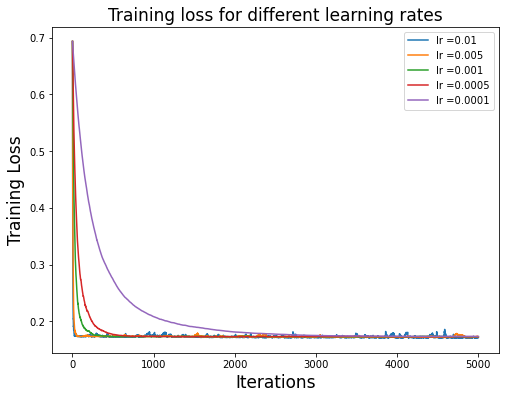

In [228]:
lr = [0.01,0.005,0.001,0.0005,0.0001]
logistic_experiment_lr(dataset_train,step_size=10, max_iter =5000,lr=lr,tol=0.01)

In [420]:
Weight,_,I = grad_descent(dataset_train, step_size=10, max_iter=10000, lr = 0.01, tol=0.001)

In [422]:
def LR_predict(qid, embedding_query, embedding_passage, W, cutoff=100):
    """
        Calculate the predicted score with given qid for each pid
        Inputs:
          qid: query ID
          embedding_query: embedding vectors for query 
          embedding_passage: embedding vectors for passage 
          W: weight obtrain from training
          cutoff: choose ranking top 'k' 
        Outputs:
          top_score: given qid, return its top 'k' pids and scores
    """
    pids,_ = qid_to_pid(qid, qid_list, pid_list)
    q_vec = embedding_query[qid]
    score_list = {}
    for pid in pids:
        p_vec = embedding_passage[pid]
        word_vec = np.hstack((1,q_vec,p_vec))
        score = pred_func(W, word_vec)
        Scores = {pid:score}
        score_list = {**score_list ,**Scores}
    top_score = dict(sorted(score_list.items(), key=lambda x: x[1], reverse=True)[:cutoff])
    return top_score

In [423]:
LR_score = {}
for qid in qid_query_valid.keys():
    top_score_LR = LR_predict(qid, embedding_valid_query, embedding_valid_passage, W=Weight, cutoff=100)
    if len(top_score_LR) == 100:
        Scores = {qid:top_score_LR}
        LR_score = {**LR_score ,**Scores}

In [485]:
mAP_LR, AP_LR = mean_AP(LR_score)

In [486]:
mAP_LR # 0.004042322132835292

0.004042322132835292

In [483]:
mNDCG_LR, NDCG_LR = mean_NDCG(LR_score)

In [484]:
mNDCG_LR # 0.020584012397022223

0.020584012397022223

In [482]:
with open('LR.txt','w') as f:
    for i in range(len(LR_score.keys())):
        qid = list(LR_score.keys())[i]
        pids = list(LR_score[qid].keys())
        for j in range(100):
            pid = pids[j]
            # qid A2 pid rank score algoname
            f.writelines([str(qid), '  A2  ', str(pid),'  ', str(j+1),'  ',str(float(LR_score[qid][pid])), '  LR', '\n'])
f.close()

## Task 3 LambdaMART Model (LM)

In [506]:
def group_split_train(qid_list):
    Group = []
    qids = set(qid_list)
    for qid in qids:
        num = qid_list.count(qid)
        Group.append(num)
    return Group

group_train = group_split_train(list(train_wv.qid))

def group_split_test(qid_list):
    Group = []
    qids = list(valid_relevant_dict.keys())
    for qid in qids:
        num = qid_list.count(qid)
        Group.append(num)
    return Group
    
group_valid = group_split_test(list(validation_data.qid))

In [603]:
models = []
Lr = [0.01,0.005,0.001]
Estimator = [100,200,300]
Depth = [5,6,7]

for i in range(len(Lr)):
    for j in range(len(Estimator)):
        for k in range(len(Depth)):
            models.append(xgb.XGBRanker(  
                           booster='gbtree',
                           objective='rank:pairwise',
                           eta=Lr[i],
                           max_depth=Depth[k], 
                           n_estimators=Estimator[j]
                           ))

In [625]:
train_labels = train_wv.values[:,5:6] # (118425, 1)
X_inputs = train_wv.values[:,3:5]
X_train = []
for i in range(len(X_inputs)):
    x = np.hstack((X_inputs[i][0], X_inputs[i][1]))
    X_train.append(x)
train_inputs = np.array(X_train) # (118425, 200)

In [577]:
LM_models = []
i = 1
for model in models:
    print('model '+ str(i))     
    LM_models.append(model.fit(train_inputs, train_labels, group=group_train, verbose=0))
    i+=1

model1
model2
model3
model4
model5
model6
model7
model8
model9
model10
model11
model12
model13
model14
model15
model16
model17
model18
model19
model20
model21
model22
model23
model24
model25
model26
model27


In [606]:
def LM_predict(qid,model,embedding_query, embedding_passage,cutoff=100):
    """
        Calculate the predicted score with given qid for each pid
        Inputs:
          qid: query ID
          model: LambdaMART Model
          embedding_query: embedding vectors for query 
          embedding_passage: embedding vectors for passage 
          cutoff: choose ranking top 'k' 
        Outputs:
          top_score: given qid, return its top 'k' pids and scores
    """    
    pids,_ =qid_to_pid(qid, qid_list, pid_list)
    q_vec = embedding_query[qid]
    score_list = {}
    group_test = []
    for pid in pids:
        p_vec = embedding_passage[pid]
        test_inputs = np.hstack((q_vec,p_vec))
        group_test.append(test_inputs)
    group_test = np.array(group_test)
    preds = model.predict(group_test)
    
    for i in range(len(pids)):
        score = float(preds[i])
        Scores = {pids[i]:score}
        score_list = {**score_list ,**Scores}
    top_score = dict(sorted(score_list.items(), key=lambda x: x[1], reverse=True)[:cutoff])
    return top_score

In [611]:
LM_scores = []
for i in range(len(LM_models)):
    print('model '+ str(i+1))
    for qid in qid_query_valid.keys():
        top_score_LM = LM_predict(qid,LM_models[i],embedding_valid_query, embedding_valid_passage,cutoff=100)    
        if len(top_score_LM) == 100:
            Scores = {qid:top_score_LM}
            LM_score = {**LM_score ,**Scores}
    LM_scores.append(LM_score)   

In [612]:
for i in range(len(LM_scores)):
    mAP_LM,_ = mean_AP(LM_scores[i])
    print('mAP of model '+ str(i+1)+' is ' + str(mAP_LM))

mAP of model 1 is 0.004270601903634963
mAP of model 2 is 0.0053858821927007736
mAP of model 3 is 0.00674419558640768
mAP of model 4 is 0.004534235651502268
mAP of model 5 is 0.004417802258000788
mAP of model 6 is 0.004236597414958064
mAP of model 7 is 0.004798381724992352
mAP of model 8 is 0.004031567193915925
mAP of model 9 is 0.0037462779668583695
mAP of model 10 is 0.005072457274011319
mAP of model 11 is 0.008196401221813511
mAP of model 12 is 0.008349054351987633
mAP of model 13 is 0.00391545369449356
mAP of model 14 is 0.005805528514239759
mAP of model 15 is 0.006676596540010008
mAP of model 16 is 0.003521957107406881
mAP of model 17 is 0.004708232762564036
mAP of model 18 is 0.003976502845477853
mAP of model 19 is 0.003943254685064625
mAP of model 20 is 0.006189783450855857
mAP of model 21 is 0.005555793163499189
mAP of model 22 is 0.004497458584100723
mAP of model 23 is 0.007001206757998135
mAP of model 24 is 0.006719254721596777
mAP of model 25 is 0.005069975803449834
mAP of mo

In [613]:
for i in range(len(LM_scores)):
    mNDCG_LM,_ = mean_NDCG(LM_scores[i])
    print('mNDCG of model '+ str(i+1)+' is ' + str(mNDCG_LM))

mNDCG of model 1 is 0.01922020755655195
mNDCG of model 2 is 0.021725613889849386
mNDCG of model 3 is 0.02399420421356681
mNDCG of model 4 is 0.01868049320868983
mNDCG of model 5 is 0.020226073097705844
mNDCG of model 6 is 0.02098625074222527
mNDCG of model 7 is 0.01853878888813317
mNDCG of model 8 is 0.019771487221408694
mNDCG of model 9 is 0.019579219146155177
mNDCG of model 10 is 0.020190952088612216
mNDCG of model 11 is 0.023972249197037394
mNDCG of model 12 is 0.025087195323652688
mNDCG of model 13 is 0.01839811626587037
mNDCG of model 14 is 0.022867156801079595
mNDCG of model 15 is 0.023895807458777837
mNDCG of model 16 is 0.016478038262553233
mNDCG of model 17 is 0.02252476011637541
mNDCG of model 18 is 0.02072597562795215
mNDCG of model 19 is 0.017580892156487657
mNDCG of model 20 is 0.021457968789105362
mNDCG of model 21 is 0.023401175199974106
mNDCG of model 22 is 0.019723425905138894
mNDCG of model 23 is 0.02321700007070808
mNDCG of model 24 is 0.02470857815405758
mNDCG of mo

In [615]:
LM_score = LM_scores[11]
with open('LM.txt','w') as f:
    for i in range(len(LM_score.keys())):
        qid = list(LM_score.keys())[i]
        pids = list(LM_score[qid].keys())
        for j in range(100):
            pid = pids[j]
            # qid A2 pid rank score algoname
            f.writelines([str(qid), '  A2  ', str(pid),'  ', str(j+1),'  ',str(float(LM_score[qid][pid])), '  LM', '\n'])
f.close()